In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from gnuradio import channels, gr, blocks, analog, digital
import datetime as dt
import random,time
import sigmf
from sigmf import SigMFFile, sigmffile, utils
from signals.communications import *
from signals.radar import * 
from tqdm.notebook import tqdm

## Global Variables

In [29]:
# Modulation parameters
sampRate = 20e6
# Metadata setup
dataDir = 'data/'
filename = 'dataset'
# Create directory if it doesn't exist
Path(dataDir).mkdir(parents=True, exist_ok=True)
# Open and close the data file to create it if it doesn't exist. This is
# necessary for the SigMFFile object below
datafile = open(dataDir+filename+'.sigmf-data', 'w+')
datafile.close()
meta = SigMFFile(
    data_file=dataDir+filename+'.sigmf-data',
    global_info={
        # TODO: Determine the data type key programatically from the data array
        SigMFFile.DATATYPE_KEY: 'cf32_le',
        SigMFFile.SAMPLE_RATE_KEY: sampRate,
        SigMFFile.AUTHOR_KEY: 'Shane Flandermeyer, shane.flandermeyer@ou.edu',
        SigMFFile.DESCRIPTION_KEY: 'Synthetic RF dataset for machine learning',
        SigMFFile.VERSION_KEY: sigmf.__version__,
    }
)
# Channel parameters
snr = 0
noise_voltage = 10**(-snr/20)
minBandwidth = 1e6
maxBandwidth = 100e6
minPulsewidth = 1e-6
maxPulsewidth = 100e-6
fD = 1
delays = [0.0, 0.9, 1.7]
mags = [1, 0.8, 0.3]
ntaps = 8
useChannelModel = True

## Main Simulation Loop

In [30]:
# Number of vectors per modulation class
nVecClass = 1000
# Number of samples per class vector
nSampsVec = 128
# Loop through all the waveform types defined in this list
np.random.seed(0)
waveforms = [LinearFMWaveform, SquareWaveform, bpsk, qpsk]
nClasses = len(waveforms)
nSampsTotal = nSampsVec*nVecClass*nClasses
data = np.zeros((nSampsTotal,), dtype=np.complex64)
nSampsProduced = 0
for wave in waveforms:
    # Flowgraph
    tb = gr.top_block()
    # Channel model
    channel = channels.dynamic_channel_model(
        sampRate, 0.01, 50, .01, 0.5e3, 8, fD, True, 4, delays, mags, ntaps, noise_voltage, 0x1337)
    # Vector sink
    sink = blocks.vector_sink_c()
    # Waveform parameters
    bandwidth = minBandwidth + np.random.rand()*(maxBandwidth-minBandwidth)
    pulsewidth = minPulsewidth + np.random.rand()*(maxPulsewidth-minPulsewidth)
    # Create signal object and associated transmitter
    sig = wave(bandwidth=bandwidth,
               pulsewidth=pulsewidth, sampRate=sampRate)
    tx = sig.transmitter(repeat=False)
    # Generate nVecClass vectors of nSampsVec samples each
    for iVec in tqdm(range(nVecClass)):
        # Random SNR from -20 to 20 dB
        snr = np.random.rand()*40-20
        noise_voltage = 10**(-snr/10)
        channel = channels.dynamic_channel_model(
            sampRate, 0.01, 50, .01, 0.5e3, 8, fD, True, 4, delays, mags, ntaps, noise_voltage, 0x1337)
        # Assemble the flowgraph
        if useChannelModel:
            tb.connect(tx, channel, sink)
        else:
            tb.connect(tx, sink)
        # Run the simulation
        tb.run()
        # Disconnect the flowgraph
        if useChannelModel:
            tb.disconnect(tx, channel, sink)
        else:
            tb.disconnect(tx, sink)
        startIdx = np.random.randint(0, len(sink.data())-nSampsVec)
        result = np.array(
            sink.data()[startIdx:startIdx+nSampsVec], dtype=np.complex64)
        # Save off the data and corresponding metadata
        # TODO: This gets slow when we try to generate lots of data
        detail = sig.detail
        metaDict = {
            SigMFFile.LABEL_KEY: sig.label,
            SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
        metaDict[sig.DETAIL_KEY] = detail.dict()
        meta.add_annotation(nSampsProduced, len(result), metadata=metaDict)
        # Normalize the energy to stay consistent with different modulations
        energy = np.sum(np.abs(result)**2)
        data[nSampsProduced:nSampsProduced+nSampsVec] = result/np.sqrt(energy)
        nSampsProduced += nSampsVec
        # TODO: Update the waveform for the next iteration
        # if isinstance(sig,RadarWaveform):
        #     bandwidth = minBandwidth + np.random.rand()*(maxBandwidth-minBandwidth)
        #     pulsewidth = minPulsewidth + np.random.rand()*(maxPulsewidth-minPulsewidth)
        #     # Create signal object and associated transmitter
        #     sig.bandwidth = bandwidth
        #     sig.pulsewidth = pulsewidth
        #     tx = sig.transmitter()
# Check for mistakes and write to file
data.tofile(dataDir+filename+'.sigmf-data')
assert meta.validate()
# Write metadata to file
meta.tofile(dataDir+filename)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

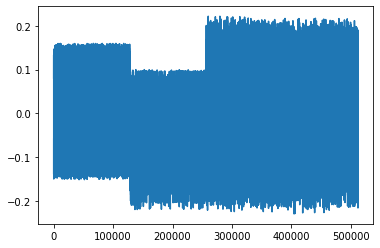

In [31]:
plt.plot(np.real(data))